<a href="https://colab.research.google.com/github/AdrianSKazi/RL-Monte-Carlo-Blackjack/blob/main/RL_Monte_Carlo_Blackjack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict

# plot_utils

In [2]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)

        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Explore BlackjackEnv

In [3]:
env = gym.make('Blackjack-v1', new_step_api=True)

Each state is a 3-tuple of:

* the player's current sum in $<0;31>$
* the dealer's face up cards in $<1;10>$
* whether or not the player has a usable ace $(no = 0, yes = 1)$

Actions:

* STICK = 0
* HIT = 1

In [4]:
print('observation_space:',env.observation_space)
print('action_space',env.action_space)

observation_space: Tuple(Discrete(32), Discrete(11), Discrete(2))
action_space Discrete(2)


In [5]:
for episode in range(3):
  state = env.reset()
  while True:
    print('state:',state)
    action = env.action_space.sample()
    print('action:',action)
    state, reward, done, _, info = env.step(action)
    if done:
      print('End of game! Reward:',reward)
      print('You won') if reward > 0 else print('You lost')
      print('\n')
      break;

state: (20, 4, False)
action: 1
End of game! Reward: -1.0
You lost


state: (12, 8, False)
action: 0
End of game! Reward: -1.0
You lost


state: (19, 10, True)
action: 0
End of game! Reward: -1.0
You lost




/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# Monte Carlo Prediction

Policy is to STICK on 80% whenever player has exceeded 18, and on 20% player HIT. When player's sum of cards is lower than 18 then on 80% he will HIT and on 20% he will STICK.

The function accepts as input:

* bj_env: This is an instance of OpenAI Gym's Blackjack environment

it return as output:

* episode: This is a list of (state, action, reward) tuples. episode[1] returns (Si+Ai+Ri+1) and episode[i][0], episode[i][1], and episode[i][2] return Si, Ai, and Ri+1, respectively.

## Single Episode

In [6]:
def generate_episode_from_limit_stochastic(bj_env):
  episode = []
  state = bj_env.reset()
  while True:
    probs = [0.8,0.2] if state[0] > 18 else [0.2,0.8] # Policy
    action = np.random.choice(np.arange(2), p=probs)
    next_state, reward, done, _, inf = bj_env.step(action)
    episode.append((state, action, reward))
    state = next_state
    if done:
      break
  return episode

In [7]:
for i in range(3):
  print(generate_episode_from_limit_stochastic(env))

[((19, 3, True), 0, 1.0)]
[((20, 3, False), 1, -1.0)]
[((12, 10, False), 0, -1.0)]


## Q-table

functions arguments:

* env: instance of an OpenAI Gym environment
* num_episodes: number of episodes that are generated through agent-environment interaction
* generate_episode: function that returns an episode of interaction
* gamma: discount rate. Must be value between 0 and 1, inclusive (default value: 1)

output of an algorithm:

* Q: dictionary (of one-dimensional arrays) where Q[s][a] is the estimated action value corresponding to state s and action a

In [8]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
  # initialize empty dictionaries of arrays
  returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
  N = defaultdict(lambda: np.zeros(env.action_space.n))
  Q = defaultdict(lambda: np.zeros(env.action_space.n))
  # loop over epiisodes
  for i_episode in range(1, num_episodes+1):
    # monitor progress
    if i_episode % 1000 == 0:
      print('\rEpisode {}/{}.'.format(i_episode, num_episodes), end='')
      # sys.stdout.flush()
    # generate an episode
    episode = generate_episode(env)
    # obtain the states, action, and rewards
    states, actions, rewards = zip(*episode) # we unpack episode so we end up of states in one tuple, actions in one tuple and rewards in one tuple
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    # update the sum of the returns, number of visits, and action-value
    # function estimates for each state-action pair in the episode
    for i, state in enumerate(states):
      returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)]) # here we use [:-(1+i)] because we always want to start discount rates from beggining so from gamma^0 so 1, in rewards we want to accumulate all rewards starting from current reward up to the end thats why we do [i:]
      N[state][actions[i]] += 1.0 # here we count how many occurances we have for each unique state-action pair so later on we can count mean of unique state-action pair
      Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]] # here we simply calculate accumulated rewards multiplied by discount rate and then count mean of each unique state-action pair by dividing by N
  return Q

Let's see how zip(*episode) works

In [9]:
episode = generate_episode_from_limit_stochastic(env)
print(episode)
states, actions, rewards = zip(*episode)
print('\nstates: ', states)
print('\nactions: ', actions)
print('\nrewards: ', rewards)

[((16, 1, True), 1, 0.0), ((16, 1, False), 1, -1.0)]

states:  ((16, 1, True), (16, 1, False))

actions:  (1, 1)

rewards:  (0.0, -1.0)


In [10]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

Episode 500000/500000.

Examplary Q state-action pair. As we can see below we have state and then we have cumulative rewards for given state for each action 0 and 1.

In [22]:
# next(iter(Q.items()))

StopIteration: 

##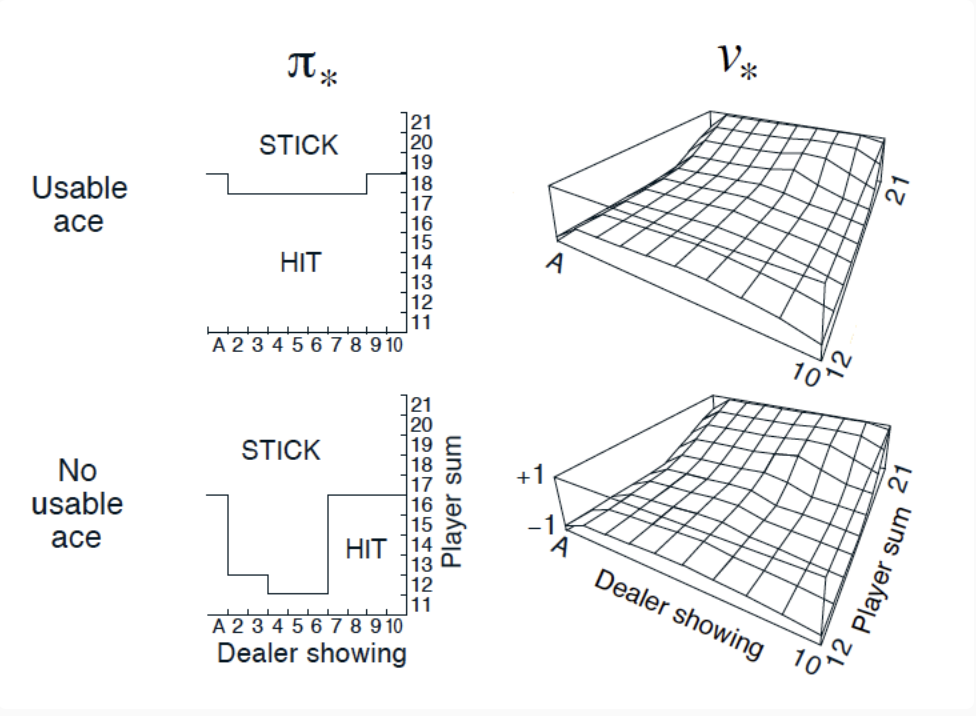 Visualizaiton

here the value of V_to_plot is calculated from Q.items() dict. It includes our policy. If we have more than 18 points our value will be $$ 1 * [.8,.2] @ value + 0 * [.2,.8] @ value = [.8,.2] @ value $$, if we have less or equal points than 18 we have $$ 0 * [.8,.2] @ value + 1 * [.2,.8] @ value = [.2,.8] @ value $$

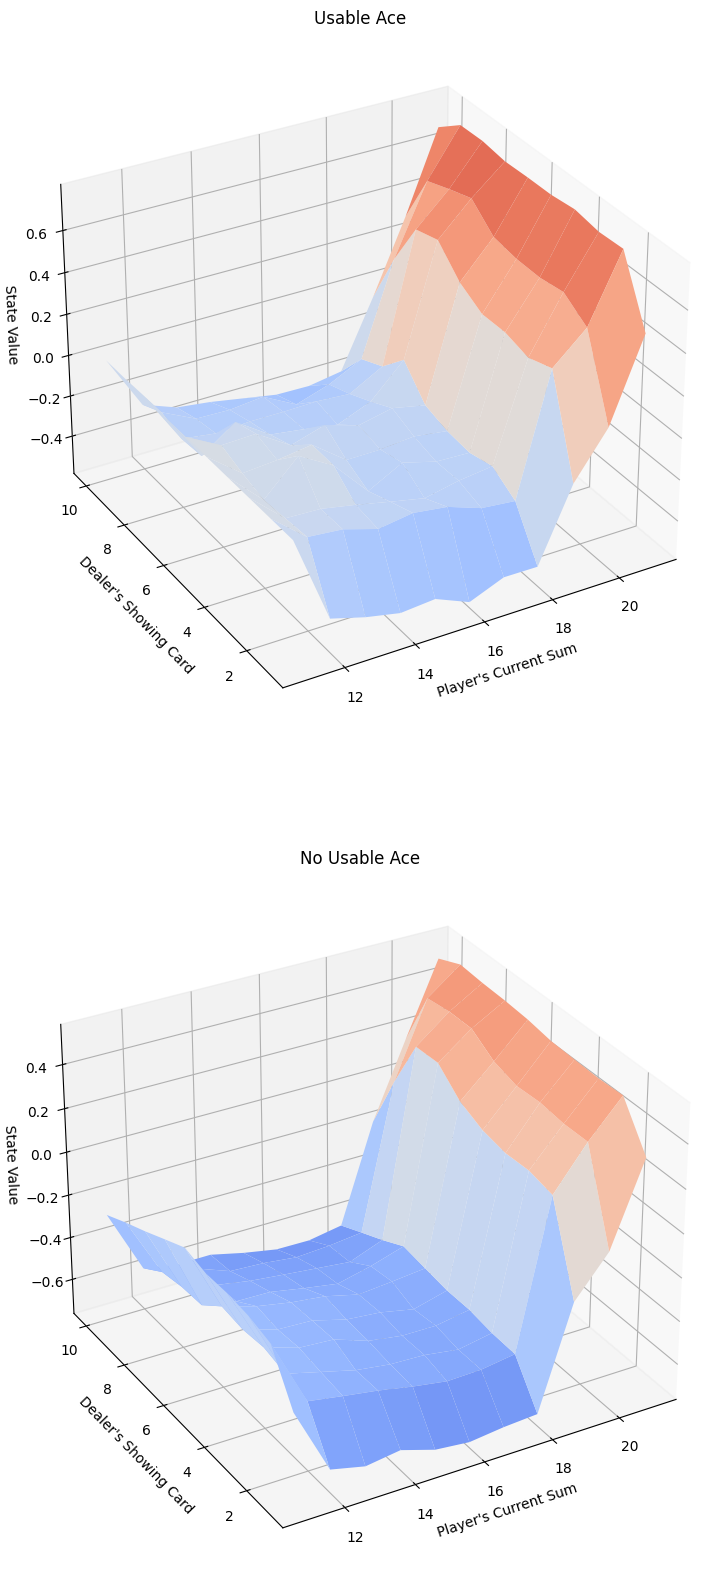

In [12]:
# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([.8,.2],v)) + (k[0]<=18)*(np.dot([.2,.8],v))) for k, v in Q.items())
# plot the state-value fucntion
plot_blackjack_values(V_to_plot)

# MC Control

Approach based on epsilon-greedy approach. Here we have 2 possible concepts:

1. Incremental Mean
2. Constant alpha


## Constant alpha

In [13]:
import sys
import gym
import numpy as np
from collections import defaultdict

In [14]:
env = gym.make('Blackjack-v1', new_step_api=True)

In [44]:
def generate_episode_from_Q(env, Q, epsilon, nA):
  ' generates an episode from following the epsilon-greedy policy '
  episode = []
  state = env.reset()
  while True:
    # here we pick epsilon-greedy approach with get_probs() if the state is already in the Q table if not got with random action
    action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) if state in Q else env.action_space.sample()
    next_state, reward, done, _, info = env.step(action)
    episode.append((state, action, reward))
    state = next_state
    if done:
      break
  return episode

def get_probs(Q_s, epsilon, nA):
  ''' obtains the action probabilities corresponding to epsilon-greedy policy '''
  # at first epsilon is quite high, e.g. .9999. Then first porbs of actions will be a bit below 0.5 if we have 2 actions as it is in blackjack (hit, stop)
  policy_s = np.ones(nA) * epsilon / nA
  # pick the best action from given state of Q
  best_a = np.argmax(Q_s)
  # we need to ensure out total probability in policy_s will equal 1
  policy_s[best_a] = 1 - epsilon + (epsilon / nA)
  return policy_s

def update_Q(env, episode, Q, alpha, gamma):
  ''' updates the action-value function estimate using the most recent episode'''
  states, actions, rewards = zip(*episode)
  # prepare for discounting
  discounts = np.array([gamma**i for i in range(len(rewards)+1)])
  for i, state in enumerate(states):
    # save old Q table
    old_Q = Q[state][actions[i]]
    # based on equation update Q table
    Q[state][actions[i]] = old_Q + alpha * (sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
  return Q

In [49]:
def mc_control(env, num_episodes, alpha, gamma = 1.0, eps_start=1.0, eps_decay=.99999, eps_min = 0.05):
  nA = env.action_space.n
  # Initialize empty dictionary of arrays
  Q = defaultdict(lambda: np.zeros(nA))
  epsilon = eps_start
  # loop over episodes
  for i_episode in range(1, num_episodes+1):
    # monitor progress
    if i_episode % 1000 == 0:
      print('Episode {}/{}'.format(i_episode, num_episodes))
    # set the value of epsilon
    epsilon = max(epsilon * eps_decay, eps_min)
    # generate an episode by following epsilon-greedy policy
    episode = generate_episode_from_Q(env, Q, epsilon, nA)
    # update the action-value function estimate using the episode
    Q = update_Q(env, episode, Q, alpha, gamma)
  # determine the policy corresponding to the final action-value function
  policy = dict((k, np.argmax(v)) for k, v in Q.items())
  return policy, Q

In [50]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 500000, 0.01, eps_min=0.01)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode 1000/500000
Episode 2000/500000
Episode 3000/500000
Episode 4000/500000
Episode 5000/500000
Episode 6000/500000
Episode 7000/500000
Episode 8000/500000
Episode 9000/500000
Episode 10000/500000
Episode 11000/500000
Episode 12000/500000
Episode 13000/500000
Episode 14000/500000
Episode 15000/500000
Episode 16000/500000
Episode 17000/500000
Episode 18000/500000
Episode 19000/500000
Episode 20000/500000
Episode 21000/500000
Episode 22000/500000
Episode 23000/500000
Episode 24000/500000
Episode 25000/500000
Episode 26000/500000
Episode 27000/500000
Episode 28000/500000
Episode 29000/500000
Episode 30000/500000
Episode 31000/500000
Episode 32000/500000
Episode 33000/500000
Episode 34000/500000
Episode 35000/500000
Episode 36000/500000
Episode 37000/500000
Episode 38000/500000
Episode 39000/500000
Episode 40000/500000
Episode 41000/500000
Episode 42000/500000
Episode 43000/500000
Episode 44000/500000
Episode 45000/500000
Episode 46000/500000
Episode 47000/500000
Episode 48000/500000
E

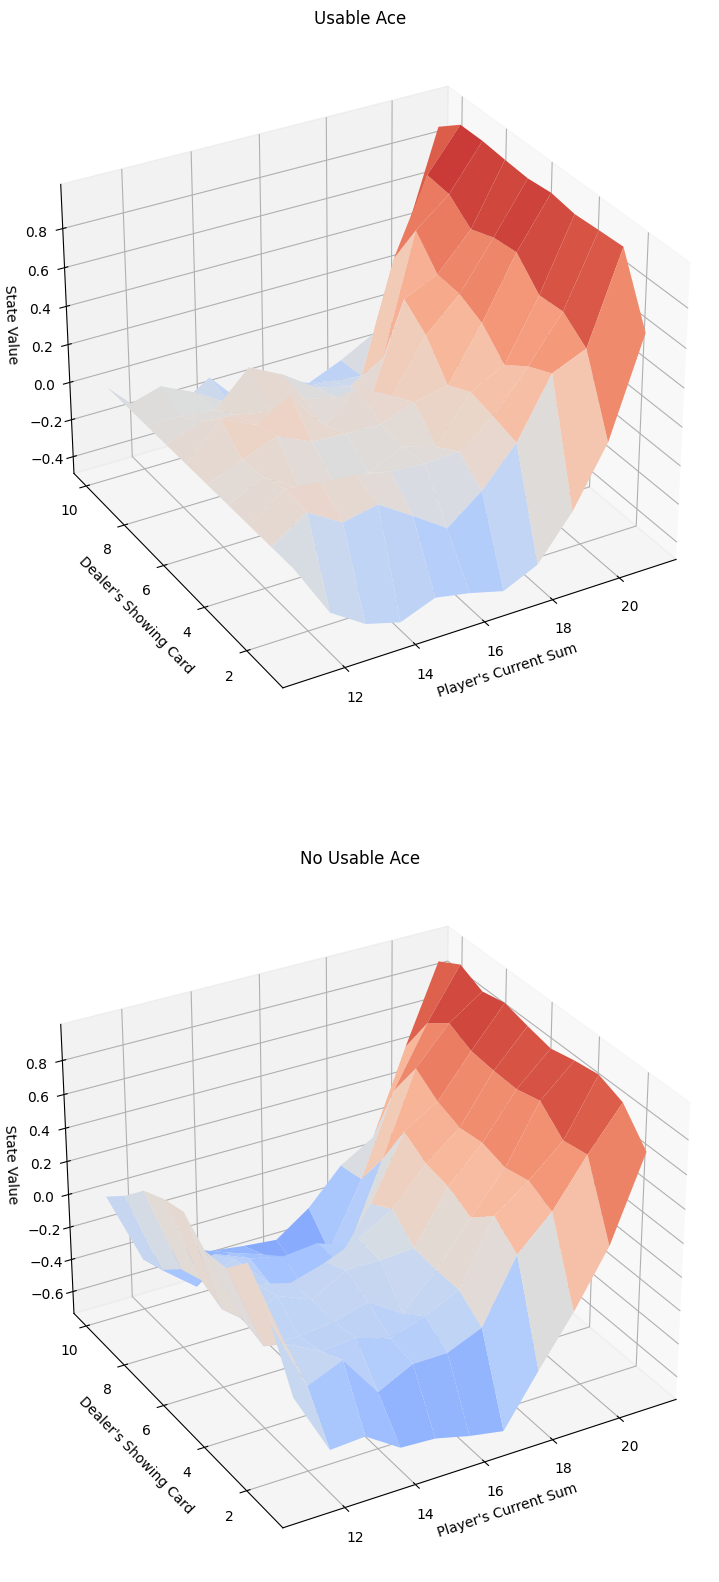

In [53]:
V = dict((k,np.max(v)) for k,v in Q.items())
plot_blackjack_values(V)

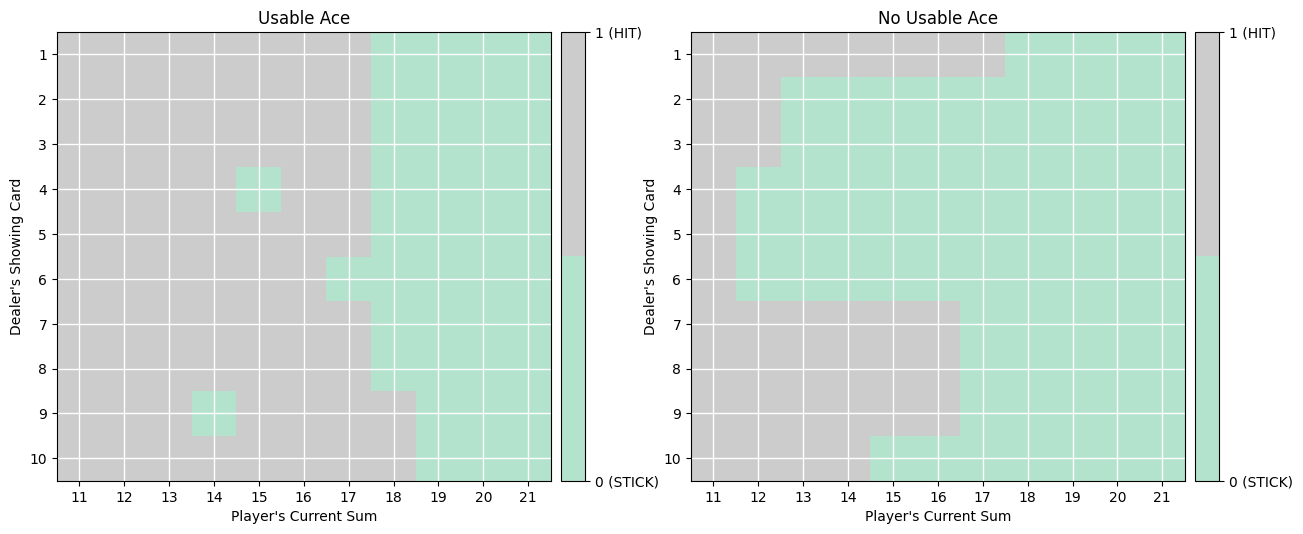

In [52]:
plot_policy(policy)